In [111]:
import pandas as pd
import numpy as np
from datetime import datetime
import xlrd

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor

from sklego.preprocessing import RepeatingBasisFunction

import matplotlib.pyplot as plt
from matplotlib import dates

from prophet import Prophet

from statsmodels.tsa.arima.model import ARIMA

%matplotlib inline 

<a id='f'></a>
## Ingestion

In [131]:
data_grower = pd.read_csv('/Users/aaroneisses/Desktop/source_application/source-assignment-data-science/data/Automatoes/GreenhouseClimate.csv')
data_weather = pd.read_csv('/Users/aaroneisses/Desktop/source_application/source-assignment-data-science/data/Weather.csv')

In [4]:
data_weather

,time,AbsHumOut,Iglob,PARout,Pyrgeo,RadSum,Rain,Rhout,Tout,Winddir,Windsp
0,43815.00000,6.220954,0.0,0.000000e+00,-72.0,215.0,0.0,80.6,6.9,32.0,4.7
1,43815.00347,6.220954,0.0,0.000000e+00,-73.0,0.0,0.0,80.6,6.9,32.0,4.7
2,43815.00694,6.205565,0.0,0.000000e+00,-76.0,0.0,0.0,80.4,6.9,32.0,4.7
3,43815.01042,6.190173,0.0,0.000000e+00,-77.0,0.0,0.0,80.2,6.9,32.0,4.7
4,43815.01389,6.162624,0.0,0.000000e+00,-75.0,0.0,0.0,80.9,6.7,32.0,4.7
...,...,...,...,...,...,...,...,...,...,...,...
47804,43980.98611,9.286397,0.0,9.999999e-01,-85.0,2992.0,0.0,71.4,15.1,2.0,4.3
47805,43980.98958,9.242139,0.0,1.000000e+00,-85.0,2992.0,0.0,71.5,15.0,2.0,4.3
47806,43980.99306,9.152067,0.0,3.350000e-08,-84.0,2992.0,0.0,70.8,15.0,2.0,3.8
47807,43980.99653,9.177802,0.0,0.000000e+00,-85.0,2992.0,0.0,71.0,15.0,2.0,3.8


<a id='f'></a>
## Preprocessing

In [5]:
data_grower = (data_grower
        .assign(time = lambda df: df["time"].apply(lambda col: pd.Timestamp(xlrd.xldate_as_datetime(col, 0))))
        .set_index('time'))

data_weather = (data_weather
        .assign(time = lambda df: df["time"].apply(lambda col: pd.Timestamp(xlrd.xldate_as_datetime(col, 0))))
        .set_index('time'))

data = data_weather.join(data_grower).resample('1H').mean()

data = (data
       .assign(period_num=lambda df: np.arange(len(df.index)),
            hour_of_day=lambda df: df.index.hour,
            month=lambda df: df.index.month))

In [6]:
data

,AbsHumOut,Iglob,PARout,Pyrgeo,RadSum,Rain,Rhout,Tout,Winddir,Windsp,...,t_ventlee_vip,t_ventwind_vip,water_sup,water_sup_intervals_sp_min,water_sup_intervals_vip_min,window_pos_lee_sp,window_pos_lee_vip,period_num,hour_of_day,month
time,,,,,,,,,,,,,,,,,,,,,
2019-12-16 00:00:00,6.226441,0.000000,0.000000,-72.083333,17.916667,0.0,81.250000,6.791667,25.333333,4.116667,...,25.0,26.0,3.833333e+00,NaN,1000.0,NaN,1.2,0,0,12
2019-12-16 01:00:00,6.237457,0.000000,0.000000,-74.230769,0.000000,0.0,84.123077,6.292308,16.000000,2.892308,...,25.0,26.0,4.000000e+00,NaN,1000.0,NaN,1.2,1,1,12
2019-12-16 02:00:00,6.284681,0.000000,0.000000,-59.000000,0.000000,0.0,85.636364,6.136364,16.000000,3.245455,...,25.0,26.0,4.872727e-08,NaN,1000.0,NaN,1.2,2,2,12
2019-12-16 03:00:00,6.451648,0.000000,0.000000,-52.750000,0.000000,0.0,88.225000,6.083333,16.000000,3.325000,...,25.0,26.0,0.000000e+00,NaN,1000.0,NaN,1.2,3,3,12
2019-12-16 04:00:00,6.574857,0.000000,0.000000,-53.153846,0.000000,0.0,90.276923,6.023077,16.000000,3.623077,...,25.0,26.0,0.000000e+00,NaN,1000.0,NaN,1.2,4,4,12
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-05-29 20:00:00,7.489756,115.363637,223.636364,-99.636364,2968.727273,0.0,44.718182,19.245455,2.000000,3.972727,...,18.0,18.0,2.200000e+01,NaN,1080.0,0.0,0.0,3980,20,5
2020-05-29 21:00:00,9.340719,20.416667,44.916667,-89.333333,2989.833333,0.0,62.333333,17.425000,2.000000,4.075000,...,18.0,18.0,2.200000e+01,NaN,1080.0,0.0,0.0,3981,21,5
2020-05-29 22:00:00,9.410785,0.000000,0.923077,-85.230769,2992.000000,0.0,68.300000,16.038462,2.000000,4.300000,...,18.0,18.0,2.200000e+01,1080.0,1080.0,0.0,0.0,3982,22,5


<a id='f'></a>
## Feature selection

In [7]:
# Drop columns which have too many NaN values
data = data.drop(columns=['int_blue_vip','int_farred_vip','int_red_vip','int_white_vip','t_vent_sp'])

In [8]:
# Fill the remaining NaN values with the average
data = data.fillna(data.mean())

<a id='f'></a>
## Training model (Simple Linear Regression)

In [77]:
data_own = data.copy()
train = data_own.loc[:'2020-05-29']
test = data_own.loc['2020-05-29':]

In [78]:
X_train = train.drop(columns="Tair")
y_train = train[['Tair']]
X_test = test.drop(columns="Tair")
y_test = test[['Tair']]

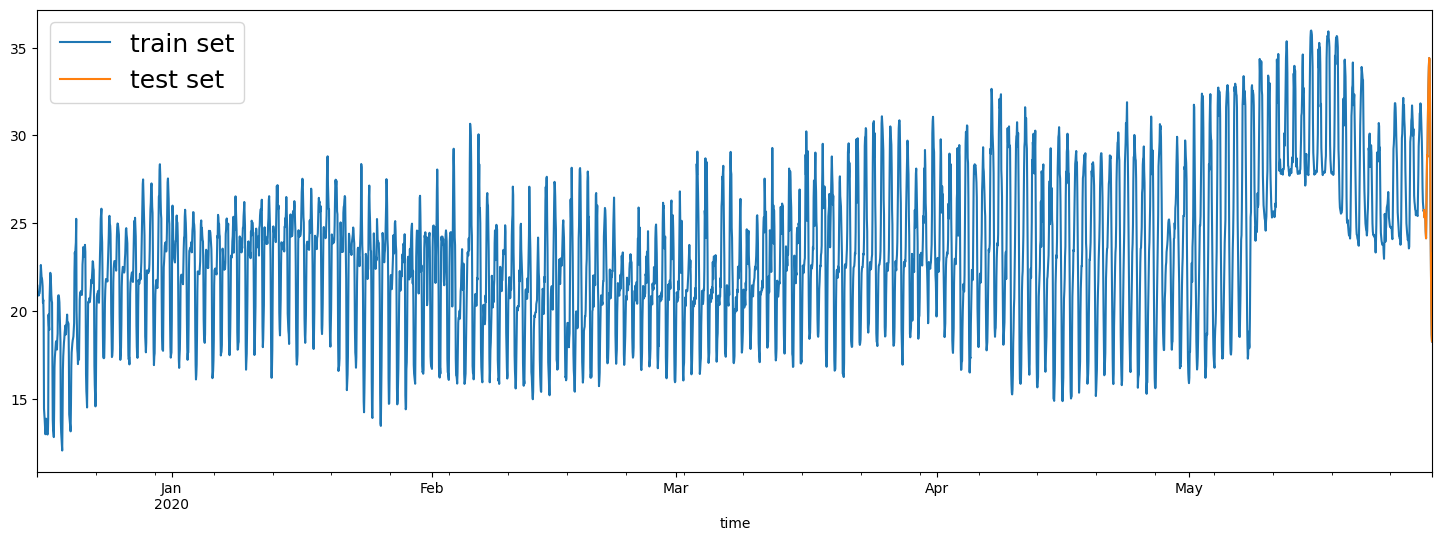

In [79]:
fig, ax = plt.subplots(figsize=(18,6))
train['Tair'].plot(ax=ax)
test['Tair'].plot(ax=ax)
ax.legend(["train set", "test set"], prop={'size': 18});

In [80]:
rbf = RepeatingBasisFunction(n_periods=24,
                             remainder='passthrough',
                             column='hour_of_day')
model = Pipeline([
    ('preprocess', rbf),
    ('scaler', StandardScaler()),
    ('model', LinearRegression())
])

lm = model.fit(X_train, y_train)
data_own['lm_pred'] = lm.predict(data_own.drop(columns="Tair"))

In [81]:
print(f"R^2 is {round(lm.score(X_test, y_test),3)}")

R^2 is 0.841


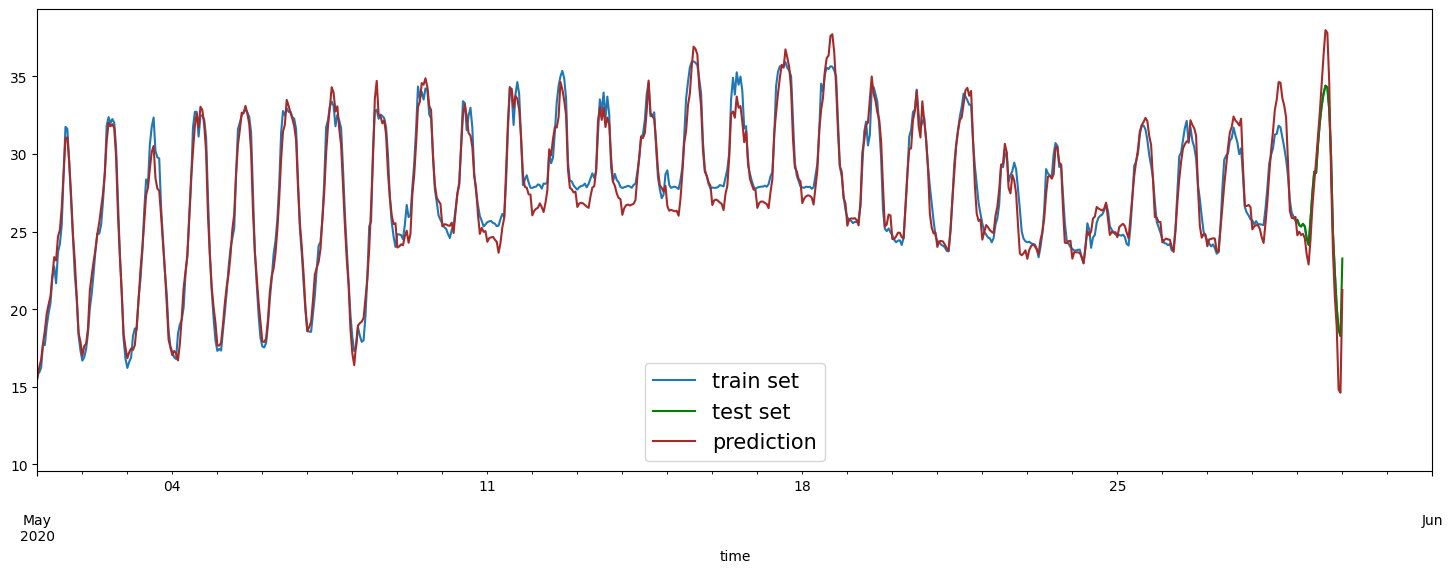

In [82]:
fig, ax = plt.subplots(figsize=(18,6))
train[['Tair']].plot(ax=ax)
test[['Tair']].plot(ax=ax, c='g')
data_own[['lm_pred']].plot(ax=ax, c='brown')
# power_daily[['smoothed']].plot(ax=ax, c='orange')
ax.legend(["train set", "test set", "prediction", "weighted moving average"], prop={'size': 15});
plt.xlim(pd.Timestamp('2020-05-01'), pd.Timestamp('2020-06-01'));

<a id='f'></a>
## Training model (Linear Regression + GridSearchCV)

In [83]:
rbf = RepeatingBasisFunction(n_periods=24,
                             remainder='passthrough',
                             column='hour_of_day')
model = Pipeline([
    ('preprocess', rbf),
    ('scaler', StandardScaler()),
    ('model', LinearRegression())
])

parameters = {
    'model__fit_intercept':[True, False]
}

tscv = TimeSeriesSplit(n_splits=6)

for train_index, test_index in tscv.split(X_train):
    print(f"TRAIN: [{train_index.min(), train_index.max()}]", 
         f"TEST: [{test_index.min(), test_index.max()}]")

TRAIN: [(0, 569)] TEST: [(570, 1138)]
TRAIN: [(0, 1138)] TEST: [(1139, 1707)]
TRAIN: [(0, 1707)] TEST: [(1708, 2276)]
TRAIN: [(0, 2276)] TEST: [(2277, 2845)]
TRAIN: [(0, 2845)] TEST: [(2846, 3414)]
TRAIN: [(0, 3414)] TEST: [(3415, 3983)]


In [84]:
gsearch = GridSearchCV(estimator=model, cv=tscv,
                        param_grid=parameters) #scoring='neg_root_mean_squared_error'

In [85]:
gsearch.fit(X_train, y_train);
gsearch.best_estimator_.steps

[('preprocess',
  RepeatingBasisFunction(column='hour_of_day', n_periods=24,
                         remainder='passthrough')),
 ('scaler', StandardScaler()),
 ('model', LinearRegression())]

In [86]:
results = pd.DataFrame(gsearch.cv_results_)
results.sort_values('rank_test_score')

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_model__fit_intercept,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,split5_test_score,mean_test_score,std_test_score,rank_test_score
0,0.052870,0.009118,0.010072,0.001886,True,{'model__fit_intercept': True},0.927947,0.907624,0.863393,0.877728,0.908065,0.525095,0.834975,0.140193,1
1,0.046466,0.014117,0.009738,0.001886,False,{'model__fit_intercept': False},-45.406348,-42.603460,-49.430799,-27.164063,-20.856419,-39.105951,-37.427840,10.143042,2


In [87]:
data_own['grid_pred'] = gsearch.predict(data_own.drop(columns="Tair"))

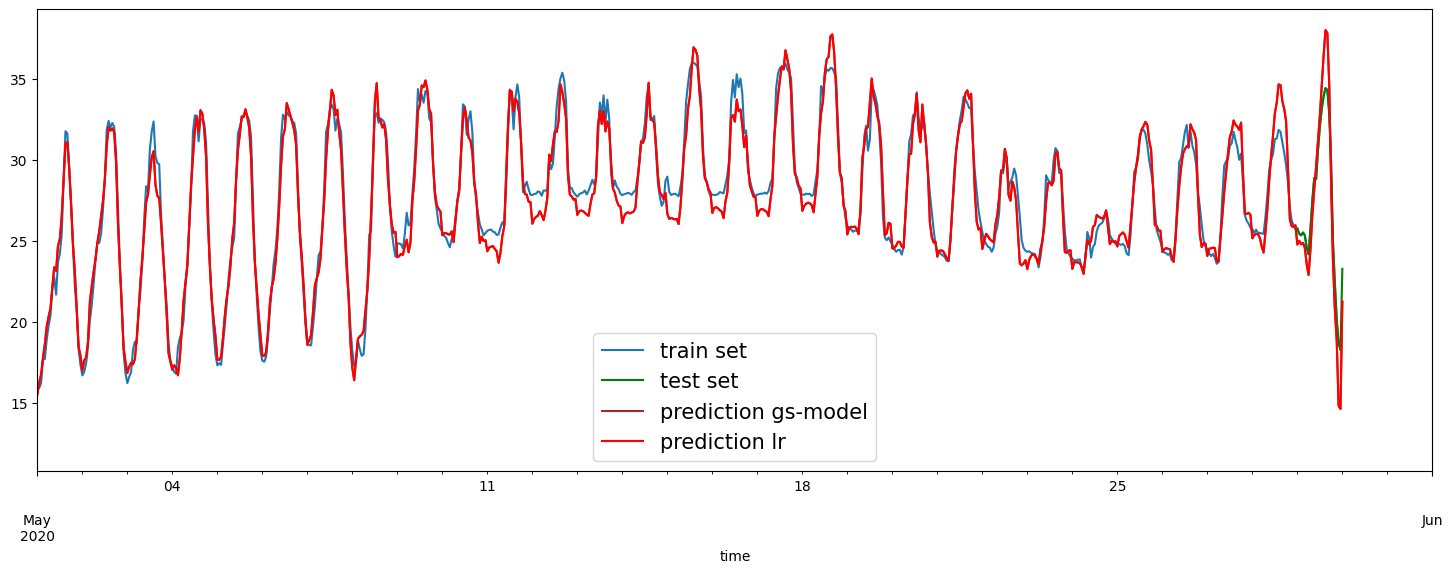

In [100]:
fig, ax = plt.subplots(figsize=(18,6))
train[['Tair']].plot(ax=ax)
test[['Tair']].plot(ax=ax, c='g')
data_own[['grid_pred']].loc['2020 May':].plot(ax=ax, c='brown')
data_own[['lm_pred']].loc['2020 May':].plot(ax=ax, c='red')
# data_own[['smoothed']].loc['2010 May':].plot(ax=ax, c='orange')
ax.legend(["train set", "test set", "prediction gs-model", "prediction lr"], prop={'size': 15});
plt.xlim(pd.Timestamp('2020-05-01'), pd.Timestamp('2020-06-01'));

In [89]:
data_own[['Tair','lm_pred','grid_pred']].head()

,Tair,lm_pred,grid_pred
time,,,
2019-12-16 00:00:00,21.450000,20.787574,20.787574
2019-12-16 01:00:00,21.038462,21.172508,21.172508
2019-12-16 02:00:00,21.036364,21.178229,21.178229
2019-12-16 03:00:00,21.025000,21.151673,21.151673
2019-12-16 04:00:00,20.892308,20.994605,20.994605


In [90]:
print(f"R^2 is {round(gsearch.score(X_test, y_test),3)}")

R^2 is 0.841


<a id='f'></a>
## Training model (Random Forest + GridSearchCV)

In [102]:
rbf = RepeatingBasisFunction(n_periods=24,
                             remainder='passthrough',
                             column='hour_of_day')
model = Pipeline([
    ('preprocess', rbf),
    ('scaler', StandardScaler()),
    ('model', RandomForestRegressor())
])

parameters = {
    'model__max_depth':[1,2,3,4,5,7,8,9,10]
}

tscv = TimeSeriesSplit(n_splits=6)

for train_index, test_index in tscv.split(X_train):
    print(f"TRAIN: [{train_index.min(), train_index.max()}]", 
         f"TEST: [{test_index.min(), test_index.max()}]")

TRAIN: [(0, 569)] TEST: [(570, 1138)]
TRAIN: [(0, 1138)] TEST: [(1139, 1707)]
TRAIN: [(0, 1707)] TEST: [(1708, 2276)]
TRAIN: [(0, 2276)] TEST: [(2277, 2845)]
TRAIN: [(0, 2845)] TEST: [(2846, 3414)]
TRAIN: [(0, 3414)] TEST: [(3415, 3983)]


In [103]:
gsearch_rf = GridSearchCV(estimator=model, cv=tscv,
                        param_grid=parameters) #scoring='neg_root_mean_squared_error'

In [104]:
gsearch_rf.fit(X_train, y_train);
gsearch_rf.best_estimator_.steps

/usr/local/lib/python3.10/site-packages/sklearn/pipeline.py:406: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
/usr/local/lib/python3.10/site-packages/sklearn/pipeline.py:406: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
/usr/local/lib/python3.10/site-packages/sklearn/pipeline.py:406: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
/usr/local/lib/python3.10/site-packages/sklearn/pipeline.py:406: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change th

/usr/local/lib/python3.10/site-packages/sklearn/pipeline.py:406: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
/usr/local/lib/python3.10/site-packages/sklearn/pipeline.py:406: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
/usr/local/lib/python3.10/site-packages/sklearn/pipeline.py:406: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
/usr/local/lib/python3.10/site-packages/sklearn/pipeline.py:406: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change th

[('preprocess',
  RepeatingBasisFunction(column='hour_of_day', n_periods=24,
                         remainder='passthrough')),
 ('scaler', StandardScaler()),
 ('model', RandomForestRegressor(max_depth=10))]

In [105]:
results = pd.DataFrame(gsearch_rf.cv_results_)
results.sort_values('rank_test_score')

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_model__max_depth,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,split5_test_score,mean_test_score,std_test_score,rank_test_score
8,3.961131,1.960515,0.024236,0.002557,10,{'model__max_depth': 10},0.797628,0.669300,0.901488,0.868086,0.947751,0.696256,0.813418,0.102905,1
7,3.618913,1.825538,0.024617,0.004580,9,{'model__max_depth': 9},0.802100,0.664399,0.902347,0.856468,0.948368,0.690457,0.810690,0.104389,2
6,3.306472,1.749953,0.022412,0.003325,8,{'model__max_depth': 8},0.797193,0.641461,0.899572,0.864143,0.945793,0.690817,0.806496,0.109617,3
5,2.937604,1.515052,0.020583,0.001404,7,{'model__max_depth': 7},0.796837,0.664282,0.891269,0.852168,0.947091,0.672280,0.803988,0.105935,4
4,2.132462,1.042826,0.018656,0.001193,5,{'model__max_depth': 5},0.780648,0.607297,0.875584,0.823570,0.941053,0.630734,0.776481,0.121796,5
3,1.756602,0.844677,0.017248,0.000710,4,{'model__max_depth': 4},0.773940,0.571490,0.858599,0.794468,0.931565,0.582899,0.752160,0.133586,6
2,1.386026,0.651080,0.017312,0.000811,3,{'model__max_depth': 3},0.747416,0.545827,0.823793,0.716376,0.913983,0.352426,0.683303,0.185533,7
1,1.031880,0.450116,0.017458,0.001326,2,{'model__max_depth': 2},0.673651,0.555906,0.740548,0.478422,0.861701,0.110037,0.570044,0.239816,8
0,0.618347,0.235157,0.017564,0.001930,1,{'model__max_depth': 1},0.468671,0.534454,0.517099,0.172636,0.561938,-0.691597,0.260534,0.445216,9


In [106]:
data_own['grid_pred_rf'] = gsearch_rf.predict(data_own.drop(columns="Tair"))

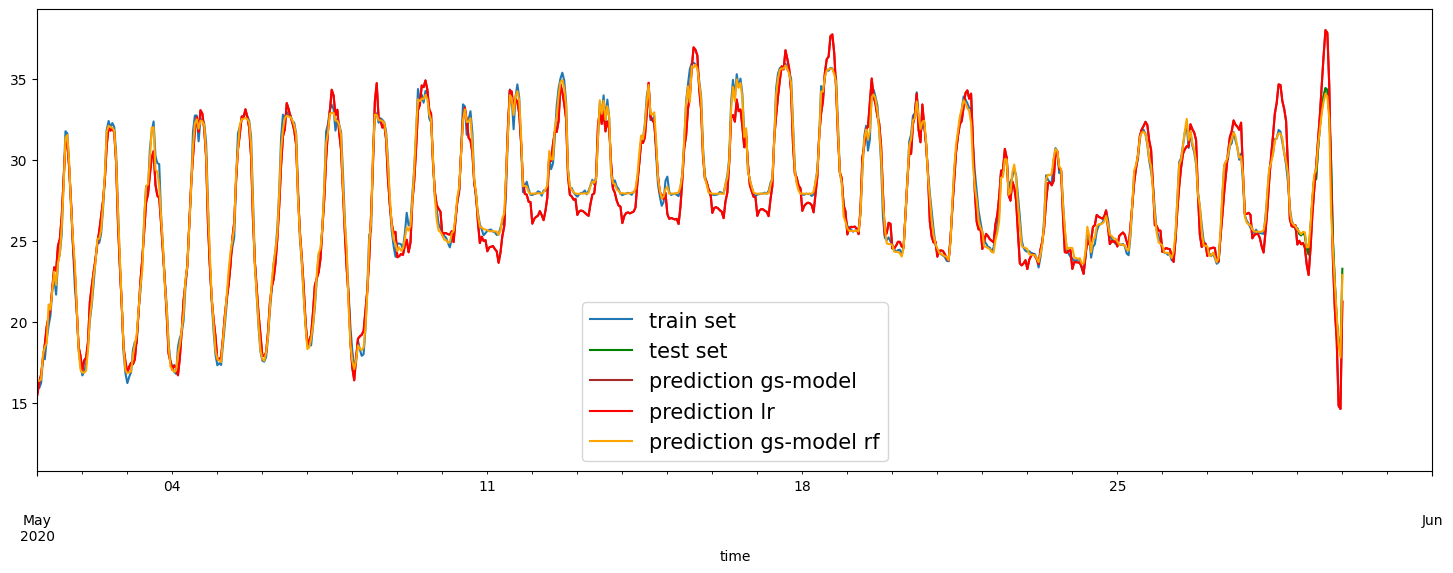

In [107]:
fig, ax = plt.subplots(figsize=(18,6))
train[['Tair']].plot(ax=ax)
test[['Tair']].plot(ax=ax, c='g')
data_own[['grid_pred']].loc['2020 May':].plot(ax=ax, c='brown')
data_own[['lm_pred']].loc['2020 May':].plot(ax=ax, c='red')
data_own[['grid_pred_rf']].loc['2010 May':].plot(ax=ax, c='orange')
ax.legend(["train set", "test set", "prediction gs-model", "prediction lr", "prediction gs-model rf"], prop={'size': 15});
plt.xlim(pd.Timestamp('2020-05-01'), pd.Timestamp('2020-06-01'));

In [108]:
print(f"R^2 is {round(gsearch_rf.score(X_test, y_test),3)}")

R^2 is 0.978


<a id='f'></a>
## Training model (ARIMA)

In [119]:
# Define the model
model_arima = ARIMA(train.Tair, order=(5, 1, 0), exog=train.drop(columns="Tair"))

# Fit the model
model_arima_fit = model_arima.fit()

# Make predictions
predictions = model_arima_fit.predict(start=len(train), end=len(train)+24, exog=test.drop(columns="Tair"))

/usr/local/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [120]:
predictions

2020-05-30 00:00:00    26.409623
2020-05-30 01:00:00    25.920929
2020-05-30 02:00:00    25.645816
2020-05-30 03:00:00    25.609348
2020-05-30 04:00:00    25.396855
2020-05-30 05:00:00    24.476487
2020-05-30 06:00:00    24.010054
2020-05-30 07:00:00    25.902932
2020-05-30 08:00:00    28.599709
2020-05-30 09:00:00    30.594172
2020-05-30 10:00:00    31.573657
2020-05-30 11:00:00    33.733437
2020-05-30 12:00:00    36.047901
2020-05-30 13:00:00    38.980908
2020-05-30 14:00:00    41.241273
2020-05-30 15:00:00    43.156902
2020-05-30 16:00:00    43.006346
2020-05-30 17:00:00    39.237276
2020-05-30 18:00:00    30.799678
2020-05-30 19:00:00    24.086191
2020-05-30 20:00:00    21.239867
2020-05-30 21:00:00    19.705049
2020-05-30 22:00:00    18.165462
2020-05-30 23:00:00    18.280852
2020-05-31 00:00:00    25.147015
Freq: H, Name: predicted_mean, dtype: float64

In [122]:
data[["Tair"]].tail(24)

,Tair
time,
2020-05-29 01:00:00,25.423077
2020-05-29 02:00:00,25.327273
2020-05-29 03:00:00,25.500000
2020-05-29 04:00:00,25.323077
2020-05-29 05:00:00,24.554545
2020-05-29 06:00:00,24.150000
2020-05-29 07:00:00,25.738462
2020-05-29 08:00:00,27.481818
2020-05-29 09:00:00,28.866667


<a id='f'></a>
## Loading model

In [133]:
import pickle

In [138]:
loaded_model = pickle.load(open("/Users/aaroneisses/Desktop/source_application/mlruns/0/6c588b3c622545da86179225adde8875/artifacts/model/model.pkl", 'rb'))


In [139]:
data_own['vscode'] = loaded_model.predict(data_own.drop(columns="Tair"))

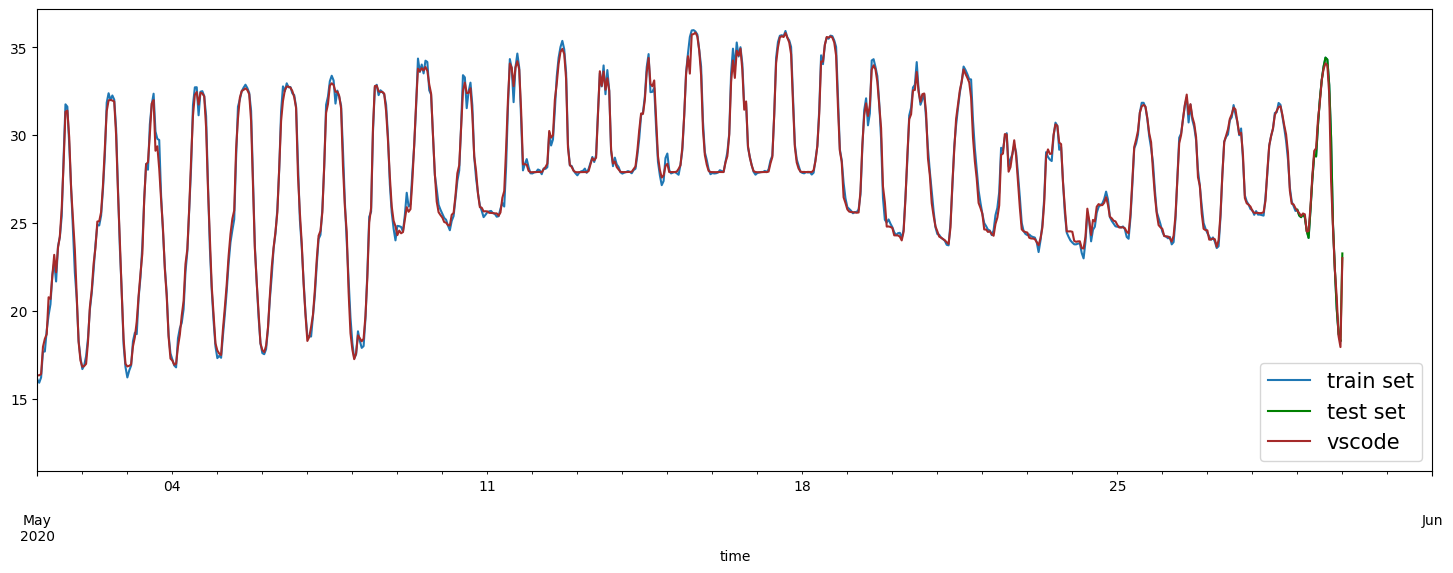

In [141]:
fig, ax = plt.subplots(figsize=(18,6))
train[['Tair']].plot(ax=ax)
test[['Tair']].plot(ax=ax, c='g')
data_own[['vscode']].loc['2020 May':].plot(ax=ax, c='brown')
# data_own[['lm_pred']].loc['2020 May':].plot(ax=ax, c='red')
# data_own[['grid_pred_rf']].loc['2010 May':].plot(ax=ax, c='orange')
ax.legend(["train set", "test set", "vscode", "prediction lr", "prediction gs-model rf"], prop={'size': 15});
plt.xlim(pd.Timestamp('2020-05-01'), pd.Timestamp('2020-06-01'));